In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.linear_model import LinearRegression

from math import sin, cos, atan2, sqrt, pi
from eda_helpers import normality_check, count_outliers
from stat_inference_helpers import custom_corr, evaluate_model

**1. Start from the Summary coming from the Exploratory Data Analysis (EDA)**

**Summary:**
 - Target: `Price` numerical continuous variable;
 - There are 6 features: 4 continuous, 2 text;
 - There are 3 missing values in target variable;
 - There are no missing values in features;
 - `Price`, `Area` and `Room` have right-skewed distribution and 56, 33, 62 outliers respectively. However if we look closer to these outliers, we'll see that all of them are just big (and thus expencive) houses. These values will not be considered as outliers;
 - There are 2 outiers in `Longitude`, that are much lower than the mean;
 - Outliers of `Latitude` create a cluster togeter with other points and will not be considered as outliers.
 - There is one point, which is an outlier niether for longitude, not for latitude, but when plotting coordinates, we see that it is far from the main distribution of points. It will be considered an outlier;
 - Most values of both text features (`Address` and `Zip`) are unique, thus not informative for prediction;
 - When removing letters from `Zip` code, there are 70 unique values, which represent areas of the city. The assumption is they are more generalized, than original format of zip code.
 

**2. Begin to process the dataset accordingly, e.g., by dealing with missing values, feature engineering and transformation;**

In [2]:
data = pd.read_csv("data/data_train.csv")

data_info = pd.read_parquet("./data/data_info.parquet")
print(f'o Shape of train dataset: {data.shape}')
display(data.sample(3))
print('o Data information')
display(data_info.transpose())
print(f'o Number of duplicate rows that will be removed: {data.duplicated().sum()}')
print(f'o Data type in Dataset: {data_info["data_type"].unique()}')
print(f"o Columns: {data_info.index.tolist()}")

o Shape of train dataset: (737, 9)


,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm,Zip region
119,"Borneolaan 342, Amsterdam",1019 KL,450000.0,85,3,4.937516,52.370995,5294.117647,0
320,"Eef Kamerbeekstraat 584 PP, Amsterdam",1095 MP,600000.0,108,4,4.967326,52.371556,5555.555556,0
442,"Komijnstraat 24, Amsterdam",1104 HP,525000.0,176,5,4.986145,52.316165,2982.954545,1


o Data information


index,Price,Address,Zip,Area,Room,Lon,Lat,Price per sqm,Zip region,Zip location,Zip district,log(Price),log(Area)
data_type,continuous,text,text,continuous,descrete,continuous,continuous,continuous,categorical,categorical,categorical,continuous,continuous
missing values,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
distribution,right_skewed,not applicable,not applicable,right_skewed,right_skewed,normal,heavy_tailed,right_skewed,not normal,not normal,not normal,right_skewed,normal
n outliers,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN


o Number of duplicate rows that will be removed: 0
o Data type in Dataset: ['continuous' 'text' 'descrete' 'categorical']
o Columns: ['Price', 'Address', 'Zip', 'Area', 'Room', 'Lon', 'Lat', 'Price per sqm', 'Zip region', 'Zip location', 'Zip district', 'log(Price)', 'log(Area)']


In [3]:
#remove duplicates:
data = data.drop_duplicates()

# remove Longitude outliers (Lon < 4.7)
data.drop(data[data['Lon']< 4.7].index, inplace=True)

# reset indexes after removing rows
data = data.reset_index()
data = data.drop(columns=['index'])
data.tail()


,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm,Zip region
732,"Cliostraat 23 HS, Amsterdam",1077 KB,1025000.0,135,4,4.875881,52.347368,7592.592593,0
733,"Prinsenstraat 4, Amsterdam",1015 DC,915000.0,88,5,4.887412,52.377742,10397.727273,0
734,"Revaleiland 383, Amsterdam",1014 ZG,690000.0,100,3,4.881116,52.393955,6900.000000,0
735,"Linnaeusstraat 243 1., Amsterdam",1093 ER,450000.0,60,4,4.928173,52.355788,7500.000000,0
736,"Van Gentstraat 6 1, Amsterdam",1055 PE,425000.0,69,4,4.851176,52.383021,6159.420290,0


**3. For supervised learning, study the relationship between features, a.k.a. independent variables (IV), with the target, a.k.a. the dependent variable (DV).**


- **a.** Study the [correlation](https://www.statisticshowto.com/probability-and-statistics/correlation-analysis/) for both **Discrete** and **Numerical** features.
- **b.** Apply $\chi^{2}$ ([chi-square](https://www.investopedia.com/terms/c/chi-square-statistic.asp)) between two **Nominal** variables;
- **c.** If necessary, transform or construct new features and re-apply the same statistical test;

**!!!** whenever possible, plot the variables to assess whether the results coming from the statistical test are driven by outliers or imbalanced facets;

* Before applying tests it makes sence to fill the missing values:

In [4]:
missing_data = data[data.isna().any(axis=1)]
missing_data

,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm,Zip region


To determine missing prices it is possible to count average price per square meter (sqm) in the neighbourhood and then multiply it by the house's area:

In [5]:
zips = []

for i in range(missing_data.shape[0]):
    zips.append(list(missing_data['Zip'])[i][:4])

data['Price per sqm'] = data['Price'] / data['Area']

for i in zips:

    #create dataframe with all houses in the neighbourhood
    data_copy = data.loc[data['Zip'].str.contains(i)]
    display(data_copy)

    # get avg price per sqm in the neighbourhood
    mean = data_copy.loc[(data_copy['Zip'].str.contains(i)), 'Price per sqm'].mean()

    #set this value to the row with missing price
    data.loc[(data['Price'].isna()) & (data['Zip'].str.contains(i)), 'Price per sqm'] = mean
    print(f'o Avg Price per sqm in the neighbourhood: {mean}')

    # get area value of the row with missing price
    area = data.loc[(data['Price'].isna()) & (data['Zip'].str.contains(i)), 'Area']

    # set missing price by multiplying average price by size of the house in sqm
    data.loc[(data['Price'].isna()) & (data['Zip'].str.contains(i)), 'Price'] = mean * area
    # display(data.loc[data['Zip'].str.contains(i)])


Add info about 'Price per sqm'

In [6]:
data_info.loc['Price per sqm', 'data_type'] = 'continuous'
data_info.loc['Price per sqm', 'missing values'] = 0
normality_check(data, data_info, ['Price per sqm'])
data_info

,data_type,missing values,distribution,n outliers
index,,,,
Price,continuous,3.0,right_skewed,0.0
Address,text,0.0,not applicable,0.0
Zip,text,0.0,not applicable,0.0
Area,continuous,0.0,right_skewed,0.0
Room,descrete,0.0,right_skewed,0.0
Lon,continuous,0.0,normal,3.0
Lat,continuous,0.0,heavy_tailed,3.0
Price per sqm,continuous,0.0,not normal,0.0
Zip region,categorical,0.0,not normal,NaN


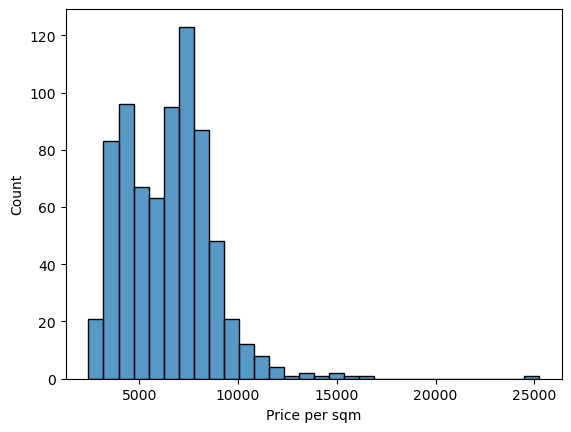

In [7]:
# plot 'Price per sqm' distribution as a histplot
plot = sns.histplot(x = data['Price per sqm'], bins = 30)

**Distribution is right-skewed**

In [8]:
data_info.loc['Price per sqm', 'distribution'] = 'right_skewed'

Check outliers of Price per sqm

In [9]:
count_outliers(data = data, data_info = data_info, features = ['Price per sqm'])

o 9 datapoints with Price per sqm > 12649.031296572282


,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm,Zip region
22,"Pieter Cornelisz. Hooftstraat 169 B, Amsterdam",1071 BW,1695000.0,117,3,4.876144,52.358928,14487.179487,0
149,"Zocherstraat 23 X, Amsterdam",1054 LR,1200000.0,81,3,4.858004,52.357400,14814.814815,0
162,"Prins Hendrikkade 512, Amsterdam",1011 TE,389000.0,30,2,4.906059,52.374085,12966.666667,0
277,"Keizersgracht 544, Amsterdam",1017 EL,5950000.0,394,10,4.887378,52.365078,15101.522843,0
418,"Dam 5 V, Amsterdam",1012 JS,4495000.0,178,5,4.894290,52.373106,25252.808989,0
554,"Leonard Bernsteinstraat 96 A, Amsterdam",1082 MR,1750000.0,130,3,4.872151,52.336348,13461.538462,0
587,"Amstel 102, Amsterdam",1017 AD,2325000.0,150,6,4.896842,52.366965,15500.000000,0
589,"Huidekoperstraat 24 F, Amsterdam",1017 ZM,2475000.0,183,4,4.897473,52.358943,13524.590164,0
644,"Nieuwe Keizersgracht 570 L, Amsterdam",1018 VG,1050000.0,63,3,4.908850,52.365524,16666.666667,0


The biggest outlier is a house, located on a Dam square, which is the most famous square of Amsterdam, so it is normal, that it is so expencive. Besides that, according to google maps, this house is a new-build or recently renovated. All other houses in outliers list are mostly located in the city center or next to tourist attractions (like row with address Zocherstraat 23 - next to Vondelpark).

In [10]:
data_info.loc['Price per sqm', 'n outliers'] = 0
data_info

,data_type,missing values,distribution,n outliers
index,,,,
Price,continuous,3.0,right_skewed,0.0
Address,text,0.0,not applicable,0.0
Zip,text,0.0,not applicable,0.0
Area,continuous,0.0,right_skewed,0.0
Room,descrete,0.0,right_skewed,0.0
Lon,continuous,0.0,normal,3.0
Lat,continuous,0.0,heavy_tailed,3.0
Price per sqm,continuous,0.0,right_skewed,0.0
Zip region,categorical,0.0,not normal,NaN


**a. Study correlations between numerical features:**

As in this dataset most of variables are not distributed normally, we have to use a custom function, that will dicide if Pearson's or Spearman's correlation test has to be applied:

In [11]:
data_info

,data_type,missing values,distribution,n outliers
index,,,,
Price,continuous,3.0,right_skewed,0.0
Address,text,0.0,not applicable,0.0
Zip,text,0.0,not applicable,0.0
Area,continuous,0.0,right_skewed,0.0
Room,descrete,0.0,right_skewed,0.0
Lon,continuous,0.0,normal,3.0
Lat,continuous,0.0,heavy_tailed,3.0
Price per sqm,continuous,0.0,right_skewed,0.0
Zip region,categorical,0.0,not normal,NaN


In [12]:
correlations_df = custom_corr(data, data_info, data.columns)
correlations_df

,method,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman,Lon,Price,-0.025781,4.846616e-01,False,737
1,Spearman,Lon,Area,0.078756,3.253710e-02,True,737
2,Spearman,Lon,Room,0.014287,6.986006e-01,False,737
3,Spearman,Lon,Lat,-0.091303,1.315111e-02,True,737
4,Spearman,Lon,Price per sqm,-0.111327,2.473536e-03,True,737
5,Spearman,Price,Area,0.720851,3.896903e-119,True,737
6,Spearman,Price,Room,0.518670,5.467193e-52,True,737
7,Spearman,Price,Lat,0.062011,9.252604e-02,False,737
8,Spearman,Price,Price per sqm,0.437909,7.000172e-36,True,737
9,Spearman,Area,Room,0.773116,1.774729e-147,True,737


As we can see here, most of statistically signifficant correlations are between a feature and a target (in this case there are 2 targets: price and price per sqm). Longitude and Latitude have no impact on price, however both have impact on price per sqm. Also there is positive correlation between Area and Rooms which seems to be fair. This features might be transformed later.

Let's plot Area and Room feature vs. Price to see the character of dependancy:

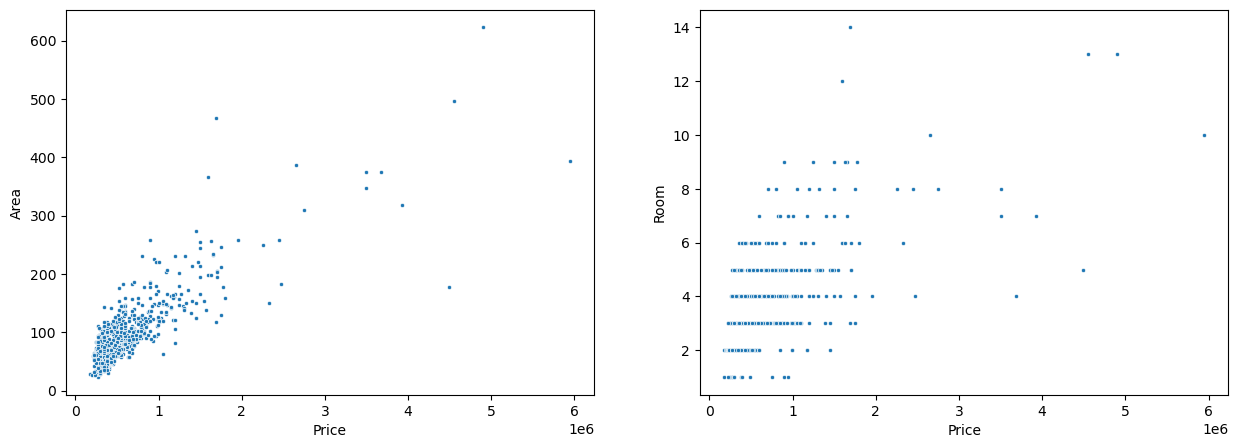

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for count, feature in enumerate(['Area', 'Room']):
    sns.scatterplot(data = data, x = 'Price', y = feature, marker='.', ax = axes.flatten()[count])

**This 2 feaures don't give us much information: none of them can be described with any known distribution.**

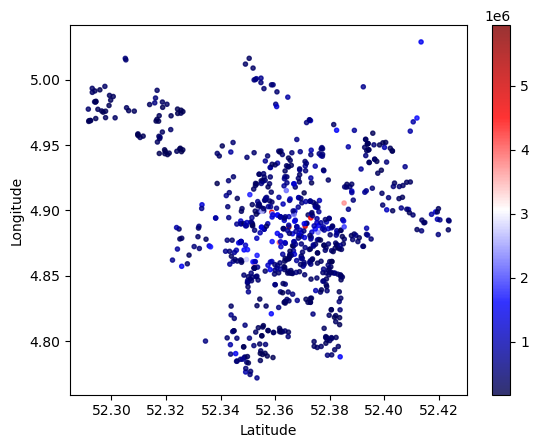

In [14]:
plt.scatter(data['Lat'], data['Lon'], alpha = .8, c = data['Price'], cmap = 'seismic', marker='.')

plt.xlabel('Latitude')
plt.ylabel('Longitude')
cbar = plt.colorbar()

This plot is more informative: the *darkest points are mostly located on the outskirts and **central** ones are more **expencive**.

**4. Create a benchmark model**

Let's create an initial model and measure the benchmark accuracy. The model will not contain custom features (Price per sqm and Distance from center) and will only require text data transformation and scaling of numerical features:
 1. Address wil be removed as it is unique for every datapoint, so has no predictive power
 2. Zip code will be cut to just numbers and checked if it is correlated with target (every digit in the Zip code has its own meaning, so instead of 1 feature there would be 4)
 3. Price, Area and Room features will be normalized.

In [15]:
# 1. remove extra or unimportant columns
data1 = data.copy().drop(columns=['Address', 'Price per sqm'])

In [16]:
# 2. transform Zip
data1['Zip city'] = np.nan
data1['Zip region'] = np.nan
data1['Zip location'] = np.nan
data1['Zip district'] = np.nan
for row in range(data1.shape[0]):
    data1.loc[row, 'Zip city'] = str(data1.loc[row, 'Zip'][0])
    data1.loc[row, 'Zip region'] = str(data1.loc[row, 'Zip'][1])
    data1.loc[row, 'Zip location'] = str(data1.loc[row, 'Zip'][2])
    data1.loc[row, 'Zip district'] = str(data1.loc[row, 'Zip'][3])
data1 = data1.drop(columns=['Zip'])

display(data1['Zip city'].value_counts())
display(data1['Zip region'].value_counts())
display(data1['Zip location'].value_counts())
display(data1['Zip district'].value_counts())

Zip city
1    737
Name: count, dtype: int64

Zip region
0    668
1     69
Name: count, dtype: int64

Zip location
1    148
5    136
6    120
7     85
0     69
9     61
2     44
3     41
8     33
Name: count, dtype: int64

Zip district
7    114
5     94
3     87
2     86
4     81
1     73
8     73
6     66
9     48
0     15
Name: count, dtype: int64

In [17]:
# Zip city is always 1, so has no predicrive power
data1 = data1.drop(columns=['Zip city'])

In [18]:
# set data info for the rest of zip features

data_info.loc['Zip region', 'data_type'] = 'categorical'
data_info.loc['Zip location', 'data_type'] = 'categorical'
data_info.loc['Zip district', 'data_type'] = 'categorical'
data_info.loc['Zip region', 'missing values'] = 0
data_info.loc['Zip location', 'missing values'] = 0
data_info.loc['Zip district', 'missing values'] = 0

In [35]:
# group values of each feature by it's unique value

import pingouin as pg

anova_df = pd.DataFrame()

for feature in ['Zip region', 'Zip location', 'Zip district']:
    # check is variances are homogeneous
    values_per_group = {
        grp_label: values
        for grp_label, values in data1.groupby(feature, observed=True)['Price']
    }
    (levene, levene_p_value) = stats.levene(*values_per_group.values())
    if levene_p_value >0.05:
        variance = 'Homogeneous'
    else:
        variance = 'Heterogeneous'

    
    groups_values = list(values_per_group.values())
    groups_sizes = []
    for i in range(len(groups_values)):
        groups_sizes.append(len(groups_values[i]))

    # ANOVA can be applied only when all the variances are homogeneous
    if variance == 'Homogeneous':
        test_type = 'One way ANOVA'
        (f_value, p_value) = stats.f_oneway(*values_per_group.values())

    else:
        test_type = 'Welch ANOVA'
        welch_df = pg.welch_anova(dv = 'Price', between= feature, data = data1)
        p_value = welch_df['p-unc']
        f_value = welch_df['F']

    dict_result = {
        "test-type": test_type,
        "feature": feature,
        "group-var": 'Price',
        "f-value": round(f_value, 3),
        "p-value": round(p_value, 3),
        "stat-sign": (p_value < 0.05),
        "variance": variance
    }
    df_result = pd.DataFrame(data=dict_result, index=[0])
    anova_df = pd.concat([anova_df, df_result], ignore_index=True) 

    
anova_df

,test-type,feature,group-var,f-value,p-value,stat-sign,variance
0,Welch ANOVA,Zip region,Price,211.973,0.000,True,Heterogeneous
1,Welch ANOVA,Zip location,Price,31.228,0.000,True,Heterogeneous
2,One way ANOVA,Zip district,Price,1.460,0.159,False,Homogeneous


Longitude, Latitude, Zip location and Zip district have no impact on target. Also, Area and room are hightly correlated, so Room will also be removed, because the its impact on target is weaker.

In [214]:
data['Zip region'] = data1['Zip region']
data1 = data1.drop(columns=['Room', 'Lon', 'Lat', 'Zip location', 'Zip district'])
data1

,Price,Area,Zip region
0,385000.0,49,0
1,930000.0,123,0
2,500000.0,70,0
3,400000.0,107,0
4,475000.0,98,0
...,...,...,...
732,1025000.0,135,0
733,915000.0,88,0
734,690000.0,100,0
735,450000.0,60,0


In [215]:
# 3. Normalize Price and Area:

data1['log(Price)'] = np.log(data1['Price'])
data1['log(Area)'] = np.log(data1['Area'])
data_info.loc['log(Price)', 'data_type'] = 'continuous'
data_info.loc['log(Area)', 'data_type'] = 'continuous'
data_info.loc['log(Price)', 'missing values'] = 0
data_info.loc['log(Area)', 'missing values'] = 0

normality_check(data1, data_info, ['log(Price)', 'log(Area)'])


,data_type,missing values,distribution,n outliers
index,,,,
Price,continuous,3.0,right_skewed,0.0
Address,text,0.0,not applicable,0.0
Zip,text,0.0,not applicable,0.0
Area,continuous,0.0,right_skewed,0.0
Room,descrete,0.0,right_skewed,0.0
Lon,continuous,0.0,normal,3.0
Lat,continuous,0.0,heavy_tailed,3.0
Price per sqm,continuous,0.0,right_skewed,0.0
Zip region,categorical,0.0,not normal,NaN


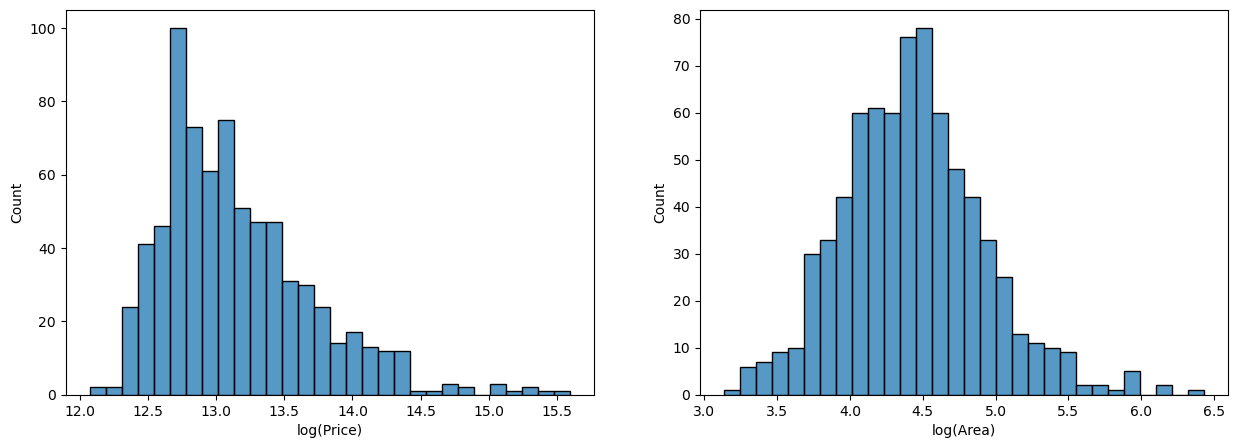

In [216]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, col in enumerate(['log(Price)', 'log(Area)']):
    plot = sns.histplot(ax=axes.flatten()[i], x = data1[col], bins = 30)

Logging Price did not make it normaly distributed, but it looks much better than initial Price distribution.

In [217]:
data_info.loc['log(Price)', 'distribution'] = 'right_skewed'
data_info

,data_type,missing values,distribution,n outliers
index,,,,
Price,continuous,3.0,right_skewed,0.0
Address,text,0.0,not applicable,0.0
Zip,text,0.0,not applicable,0.0
Area,continuous,0.0,right_skewed,0.0
Room,descrete,0.0,right_skewed,0.0
Lon,continuous,0.0,normal,3.0
Lat,continuous,0.0,heavy_tailed,3.0
Price per sqm,continuous,0.0,right_skewed,0.0
Zip region,categorical,0.0,not normal,NaN


In [218]:
correlations_df = custom_corr(data1, data_info, features=['log(Price)', 'log(Area)', 'Zip region'])
correlations_df

,method,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman,log(Area),log(Price),0.720851,3.896903e-119,True,737


According to correlation matrix, the data is ready to be fed to the initial model to get benchmark accuracy:

In [219]:
X1 = data1.drop(columns=['Price', 'Area', 'log(Price)'])
y1 = data1['log(Price)']

model1 = LinearRegression()
model1.fit(X1, y1)
y_pred1 = model1.predict(X1)

In [220]:
# back transformation from log of price to price
y_pred1 = np.exp(y_pred1)

In [221]:
results = pd.DataFrame()
results['Model'] = ''
results['List of used features'] = []
results['Target'] = ''
results['RMSE'] = np.nan
results['MAE'] = np.nan
results['r_value'] = np.nan
results['corr_coef'] = np.nan

In [222]:
rmse1, mae1, r_value1, corr1 = evaluate_model('Linear Regression', list(X1.columns), 'log(Price)', data1['Price'], y_pred1, results)
results

,Model,List of used features,Target,RMSE,MAE,r_value,corr_coef
0,Linear Regression,"[Zip region, log(Area)]",log(Price),325388.852788,159374.459167,0.642526,0.813826


This model is no good: r-value is very low as well as correlation coefficient. In the next file futher feature engineeting and model selection/regularization will be performed to get better results

In [223]:
# save all the dataframes for futher use

results.to_parquet("./data/results.parquet", index=False)
data_info.to_parquet("./data/data_info.parquet")
data.to_csv("./data/data_train.csv", index=False)


## Summary:


1. Area and Room features are correlated
2. Lon, Lat, Address have no impact on target
3. It is prommising to create a 'Distance' feature out of Lon and Lat
4. The whole Zip code has no influence on target as well. However, the second digit, that means Region and has values [0,1]
5. Price per square meter could be an alternative target. This assumption requires a proof.